# TP : Proximal coordinate descent method on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal coordinate descent

for 
- Lasso / L1 linear regression
- non-negative least squares (NNLS)

models.

The proximal operators we will use are the 
- L1 penalization
- indicator function of $\mathbb{R}_+$

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 23th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 17 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "peter"
ln1 = "martigny"
fn2 = "benoît"
ln2 = "choffin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_cd", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_cd_martigny_peter_and_choffin_benoît.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse positive vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

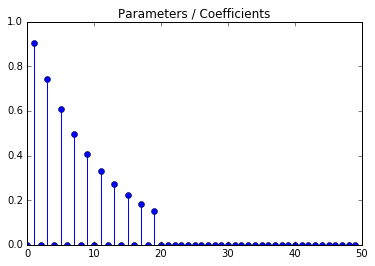

In [4]:
n_features, n_samples = 50, 1000
idx = np.arange(n_features)
coefs = (idx % 2) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

## Proximal operators and Solver


We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Lasso penalization, where $g(x) = s \|x\|_1$
- Indicator function of $\mathbb{R}_+$, where $g(x) = i_{x \geq 0}(\cdot)$ (this is the convex indicator)

where $s \geq 0$ is a regularization parameter.

We want to minimize:
$$
\arg\min_x F(x)
$$
with
$$
 F(x) = \frac{1}{2} \|b - Ax\|^2 + g(x)
$$

## Questions

- Code a function that computes $g(x)$ and $\text{prox}_g(x)$ for in both cases
- Justify why proximal coordinate descent can be applied to obtain a minimum of such objective functions.
- Starting from the code provided in the notebook presented during the coordinate descent course as well as the code below, implement a proximal coordinate method for both penalties.
- Evaluate qualitatively the convergence when varying the conditioning of the problem.
- Bonus: Try to show that coordinate is much less affected by bad conditioning that proximal gradient descent.

### You are expected to implement the smart residuals updates !

### You are very welcome to reuse everything you did for TP1 !

#### Functions to compute g and its proximal function

In [12]:
def lasso(x, s):
    aux = np.abs(x).sum()
    return s * aux

def prox_lasso(x, s, t=1.):
    aux = np.abs(x)
    result = np.sign(x) * np.maximum((aux - s*t), 0)
    return result

def r_indicator(x):
    if min(x) < 0:
        return np.inf
    else:
        return 0
    
def prox_r_indicator(x, s, t=1.):
    temp = np.where(x < 0)
    x[temp] = 0
    return x   

The first term of the objective function is convex differentiable, and the second term is linearly separable and each $g_i$ is convex. Indeed, for the Lasso regularization, we have: $\forall i = 1,...,n \quad g_i(x^{(i)}) = \text{sign}(x^{(i)})\:(|x^{(i)}| - st)_+$ and for the indicator function of $\mathbb{R}_{+}$ we have: $\forall i = 1,...,n \quad g_i(x^{(i)}) = i_{x \geq 0}(x^{(i)})$

In [18]:
# We redefine a 1D proximal operator for the indicator function
def prox_r_indicator1D(x):
    if x < 0:
        return 0
    else:
        return x
    
def gradient_i(x, i):
    return np.dot(A[:, i].T, np.dot(A, x) - y)

def cd_linreg(x0, A, b, g, prox_g, s=0., n_iter=50,
              x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coordinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = 0.5 * linalg.norm(b - A.dot(x))**2 + g(x, s)
    objectives.append(obj)
    
    Li = np.sum(A * A, axis=0)
    
    x_new[0] = prox_g(x_new[0] - (1/Li[0]) * np.dot(A[:, 0].T, np.dot(A, x_new) - b), s = s)
    residuals = np.dot(A, x_new) - b

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))

    for k in range(1, n_iter + 1):

        i = k % n_features  
        
        alpha = x_new[i] - x[i]
        residual = residual + alpha * A[:, i]
        
        
        x{i - 1} = x_new[i - 1]
        x_new[i] = prox_g(x_new[i] - (1/Li[i]) * np.dot(A[:, i], residuals), s = s)
        
        
    
        obj = 0.5 * linalg.norm(b - A.dot(x))**2 + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

SyntaxError: invalid syntax (<ipython-input-18-3b7c323ceee5>, line 39)

In [21]:
A, b = simu_linreg(coefs = coefs)
Li = np.sum(A * A, axis=0)
x_new = np.random.randn(n_features)
print(x_new)
x_new[0] = prox_lasso(x_new[0] - (1/Li[0]) * np.dot(A[:, 0].T, np.dot(A, x_new) - b), s = 0)

[ 0.73 -0.83  0.46 -1.25  0.58  2.12 -0.99 -0.43  0.49 -2.22 -0.22 -1.21
 -1.83 -0.71 -0.05 -0.11  0.06 -1.18  1.21 -0.53  1.41 -0.84  0.21  1.14
 -1.16  0.83 -0.36  0.47  0.04 -0.59  0.46  0.22  1.36  0.1  -0.66  0.05
  0.37 -0.13  0.35 -1.95  1.14  0.38 -1.23 -1.85 -0.66 -2.53 -0.07  0.89
 -0.16 -1.8 ]


In [22]:
x_new

array([ 1.28, -0.83,  0.46, -1.25,  0.58,  2.12, -0.99, -0.43,  0.49,
       -2.22, -0.22, -1.21, -1.83, -0.71, -0.05, -0.11,  0.06, -1.18,
        1.21, -0.53,  1.41, -0.84,  0.21,  1.14, -1.16,  0.83, -0.36,
        0.47,  0.04, -0.59,  0.46,  0.22,  1.36,  0.1 , -0.66,  0.05,
        0.37, -0.13,  0.35, -1.95,  1.14,  0.38, -1.23, -1.85, -0.66,
       -2.53, -0.07,  0.89, -0.16, -1.8 ])